# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
pip install hvplot

In [2]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [3]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [5]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [6]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [7]:
df.head(15)

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078
2018-02-06,8,7701.250000
2018-02-07,36,7592.720215
2018-02-08,30,8260.690430
2018-02-09,44,8696.830078
2018-02-10,54,8569.290039


In [8]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X first 5 values:\n{X[:5]} \n")
print (f"y first 5 values:\n{y[:5]}")

X first 5 values:
[[30 15 40 24 11  8 36 30 44 54]
 [15 40 24 11  8 36 30 44 54 31]
 [40 24 11  8 36 30 44 54 31 42]
 [24 11  8 36 30 44 54 31 42 35]
 [11  8 36 30 44 54 31 42 35 55]] 

y first 5 values:
[[ 8084.609863]
 [ 8911.269531]
 [ 8544.69043 ]
 [ 9485.639648]
 [10033.75    ]]


In [10]:
print(f"len(X): {len(X)} \n")
print(f"len(y): {len(y)}")

len(X): 532 

len(y): 532


In [11]:
# Use 70% of the data for training and the remaineder for testing
# To avoid the dataset being randomized, we will manually split the data using array slicing.
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [12]:
# Sanity check
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

[[30 15 40 24 11  8 36 30 44 54]
 [15 40 24 11  8 36 30 44 54 31]
 [40 24 11  8 36 30 44 54 31 42]
 [24 11  8 36 30 44 54 31 42 35]
 [11  8 36 30 44 54 31 42 35 55]]
[[40 46 38 48 48 43 43 41 38 63]
 [46 38 48 48 43 43 41 38 63 65]
 [38 48 48 43 43 41 38 63 65 59]
 [48 48 43 43 41 38 63 65 59 59]
 [48 43 43 41 38 63 65 59 59 61]]
[[ 8084.609863]
 [ 8911.269531]
 [ 8544.69043 ]
 [ 9485.639648]
 [10033.75    ]]
[[3924.23999 ]
 [3974.050049]
 [3937.040039]
 [3983.530029]
 [4149.089844]]


In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
# scale both features and target sets.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
# Sanity check
X_train[:3]

array([[0.25287356, 0.08045977, 0.36781609, 0.18390805, 0.03448276,
        0.        , 0.31395349, 0.24418605, 0.40697674, 0.52325581],
       [0.08045977, 0.36781609, 0.18390805, 0.03448276, 0.        ,
        0.32183908, 0.24418605, 0.40697674, 0.52325581, 0.25581395],
       [0.36781609, 0.18390805, 0.03448276, 0.        , 0.32183908,
        0.25287356, 0.40697674, 0.52325581, 0.25581395, 0.38372093]])

In [15]:
X_train.shape

(372, 10)

In [16]:
X_train.shape[0]

372

In [17]:
X_train.shape[1]

10

In [18]:
# The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need 
# to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).
# Reshape the features for the model
# Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.25287356]
  [0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.31395349]
  [0.24418605]
  [0.40697674]
  [0.52325581]]

 [[0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.24418605]
  [0.40697674]
  [0.52325581]
  [0.25581395]]] 

X_test sample values:
[[[0.36781609]
  [0.43678161]
  [0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.39534884]
  [0.37209302]
  [0.3372093 ]
  [0.62790698]]

 [[0.43678161]
  [0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.40229885]
  [0.37209302]
  [0.3372093 ]
  [0.62790698]
  [0.65116279]]]


## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [21]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [22]:
# Summarize the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [23]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
372/372 [==============================] - 6s 8ms/step - loss: 0.0667
Epoch 2/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0717
Epoch 3/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0743
Epoch 4/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0777
Epoch 5/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0724
Epoch 6/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0735
Epoch 7/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0708
Epoch 8/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0682
Epoch 9/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0642
Epoch 10/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0712


## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [24]:
# Evaluate the model
# Use the evaluate method using the testing data.

model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 5ms/step - loss: 0.1219


0.12194047123193741

In [25]:
# Make some predictions
# Make some closing price predictions using LSTM RNN model and testing data.

predicted = model.predict(X_test)

In [26]:
# Recover the original prices instead of the scaled version
# Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()},
     index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4717.979980
2019-02-21,3974.050049,4793.755371
2019-02-22,3937.040039,4861.982910
2019-02-23,3983.530029,4912.349121
2019-02-24,4149.089844,4949.642578


In [28]:
# Sanity check
stocks

,Real,Predicted
2019-02-20,3924.239990,4717.979980
2019-02-21,3974.050049,4793.755371
2019-02-22,3937.040039,4861.982910
2019-02-23,3983.530029,4912.349121
2019-02-24,4149.089844,4949.642578
...,...,...
2019-07-25,9772.139648,4552.203125
2019-07-26,9882.429688,4522.482422
2019-07-27,9847.450195,4507.348633
2019-07-28,9478.320313,4461.392578


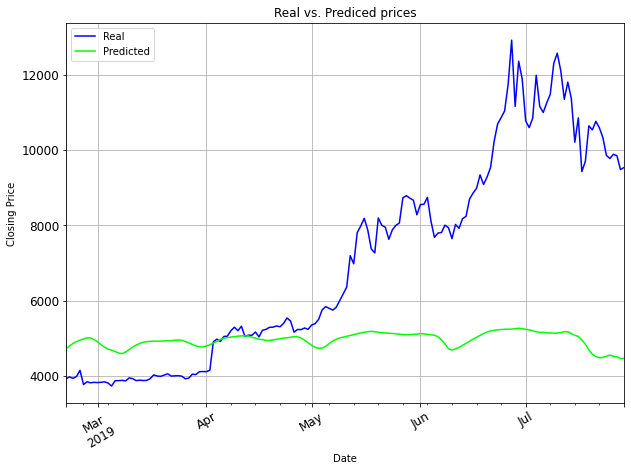

In [29]:
# Plot the real vs predicted values as a line chart

stocks.plot(figsize = (10, 7), fontsize=12, rot=30, title = "Real vs. Prediced prices", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

In [30]:
from sklearn.metrics import mean_squared_error

# calculating the root mean squared error regression loss.(squared=False)
mean_squared_error(real_prices, predicted_prices, squared=False)

3380.522636818757

# Trying different window size=5

In [31]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column1 = 0
target_column1 = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X first 5 values:\n{X[:5]} \n")
print (f"y first 5 values:\n{y[:5]}")

X first 5 values:
[[30 15 40 24 11]
 [15 40 24 11  8]
 [40 24 11  8 36]
 [24 11  8 36 30]
 [11  8 36 30 44]] 

y first 5 values:
[[7701.25    ]
 [7592.720215]
 [8260.69043 ]
 [8696.830078]
 [8569.290039]]


In [32]:
print(f"len(X): {len(X)} \n")
print(f"len(y): {len(y)}")

len(X): 537 

len(y): 537


In [33]:
# Use 70% of the data for training and the remaineder for testing
# To avoid the dataset being randomized, we will manually split the data using array slicing.
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [34]:
# Sanity check
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

[[30 15 40 24 11]
 [15 40 24 11  8]
 [40 24 11  8 36]
 [24 11  8 36 30]
 [11  8 36 30 44]]
[[48 48 43 43 41]
 [48 43 43 41 38]
 [43 43 41 38 63]
 [43 41 38 63 65]
 [41 38 63 65 59]]
[[7701.25    ]
 [7592.720215]
 [8260.69043 ]
 [8696.830078]
 [8569.290039]]
[[3670.919922]
 [3912.570068]
 [3924.23999 ]
 [3974.050049]
 [3937.040039]]


In [35]:
# Use the MinMaxScaler to scale data between 0 and 1.
# scale both features and target sets.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [36]:
# Sanity check
X_train[:7]

array([[0.25287356, 0.08045977, 0.36781609, 0.18390805, 0.03448276],
       [0.08045977, 0.36781609, 0.18390805, 0.03448276, 0.        ],
       [0.36781609, 0.18390805, 0.03448276, 0.        , 0.32183908],
       [0.18390805, 0.03448276, 0.        , 0.32183908, 0.25287356],
       [0.03448276, 0.        , 0.32183908, 0.25287356, 0.4137931 ],
       [0.        , 0.32183908, 0.25287356, 0.4137931 , 0.52873563],
       [0.32183908, 0.25287356, 0.4137931 , 0.52873563, 0.26436782]])

In [37]:
X_train.shape

(375, 5)

In [38]:
# The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need 
# to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).
# Reshape the features for the model
# Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.25287356]
  [0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]]

 [[0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]]] 

X_test sample values:
[[[0.45977011]
  [0.45977011]
  [0.40229885]
  [0.40229885]
  [0.37931034]]

 [[0.45977011]
  [0.40229885]
  [0.40229885]
  [0.37931034]
  [0.34482759]]]


In [39]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [40]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [41]:
# Summarize the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [42]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
375/375 [==============================] - 5s 5ms/step - loss: 0.0756
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0656
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0735
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0752
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0758
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0685
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0688
Epoch 8/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0678
Epoch 9/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0678
Epoch 10/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0634


In [43]:
# Evaluate the model
# Use the evaluate method using the testing data.

model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 3ms/step - loss: 0.1180


0.11801585555076599

In [44]:
# Make some predictions
# Make some closing price predictions using LSTM RNN model and testing data.

predicted = model.predict(X_test)

In [45]:
# Recover the original prices instead of the scaled version
# Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [46]:
# Create a DataFrame of Real and Predicted values
stocks1 = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()},
     index = df.index[-len(real_prices): ]) 
stocks1.head()

,Real,Predicted
2019-02-18,3670.919922,4428.788574
2019-02-19,3912.570068,4325.528809
2019-02-20,3924.239990,4300.989746
2019-02-21,3974.050049,4464.876953
2019-02-22,3937.040039,4682.107910


In [47]:
# Sanity check
stocks1

,Real,Predicted
2019-02-18,3670.919922,4428.788574
2019-02-19,3912.570068,4325.528809
2019-02-20,3924.239990,4300.989746
2019-02-21,3974.050049,4464.876953
2019-02-22,3937.040039,4682.107910
...,...,...
2019-07-25,9772.139648,4104.605957
2019-07-26,9882.429688,3998.702393
2019-07-27,9847.450195,4022.882080
2019-07-28,9478.320313,3877.850098


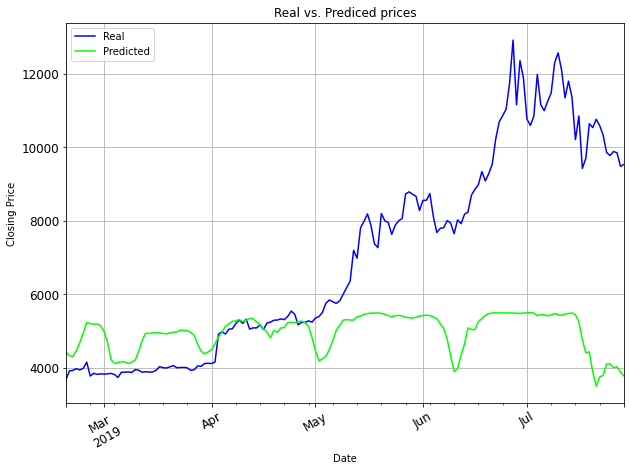

In [48]:
# Plot the real vs predicted values as a line chart

stocks1.plot(figsize = (10, 7), fontsize=12, rot=30, title = "Real vs. Prediced prices", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

In [49]:
from sklearn.metrics import mean_squared_error

# calculating the root mean squared error regression loss.(squared=False)
mean_squared_error(real_prices, predicted_prices, squared=False)

3325.677206860421

# BONUS 1: function to experiment with different window size from 1 to 10

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

recurr = []
for i in range(1,11):
  window_size = i
  print()
  print(f"*************************This is the model with window_size:{i}*************************")

  # Column index 0 is the 'fng_value' column
  # Column index 1 is the `Close` column
  feature_column = 0
  target_column = 1
  X, y = window_data(df, window_size, feature_column, target_column)

  # Use 70% of the data for training and the remaineder for testing
  # To avoid the dataset being randomized, we will manually split the data using array slicing.
  # Use 70% of the data for training and the remainder for testing
  split = int(0.7 * len(X))
  X_train = X[: split]
  X_test = X[split:]
  y_train = y[: split]
  y_test = y[split:]

  # Use the MinMaxScaler to scale data between 0 and 1.
  # scale both features and target sets.
  scaler = MinMaxScaler()
  scaler.fit(X)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  scaler.fit(y)
  y_train = scaler.transform(y_train)
  y_test = scaler.transform(y_test)

  # The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need 
  # to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).
  # Reshape the features for the model
  # Reshape X_train and X_test to fit the model requirements (samples, time steps, features)
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Build the LSTM model. 
  # The return sequences need to be set to True if you are adding additional LSTM layers, but 
  # You don't have to do this for the final layer. 
  # Note: The dropouts help prevent overfitting
  # Note: The input shape is the number of time steps and the number of indicators
  # Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

  # Define the LSTM RNN model.
  model = Sequential()

  number_units = 30
  dropout_fraction = 0.2

  # Layer 1
  model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(dropout_fraction))
  # Layer 2
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 3
  model.add(LSTM(units=number_units))
  model.add(Dropout(dropout_fraction))
  # Output layer
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer="adam", loss="mean_squared_error")

  # Summarize the model
  model.summary()

  # Train the model
  # Use at least 10 epochs
  # Do not shuffle the data
  # Experiement with the batch size, but a smaller batch size is recommended
  model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)
  
  # Evaluate the model
  # Use the evaluate method using the testing data.
  model.evaluate(X_test, y_test)

 
  # Make some closing price predictions using LSTM RNN model and testing data.
  predicted = model.predict(X_test)
  
  # Recover the original prices instead of the scaled version
  # Use the inverse_transform() method of the scaler to decode the scaled values to their original scale.
  predicted_prices = scaler.inverse_transform(predicted)
  real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
  

  # calculating the root mean squared error regression loss.(squared=False)
  root_mse = mean_squared_error(real_prices, predicted_prices, squared=False)
 
  
  recurr.append({
    "window_size": i,
    "model": "LSTM",
    "summery":model.summary(),
    "evaluate":model.evaluate(X_test, y_test),
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
    "root_mse": root_mse,
    "real_prices": real_prices,
    "index": df.index[-len(real_prices): ]
    })


*************************This is the model with window_size:1*************************
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 30)             3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
________________________________

#BONUS 2: function to display the real vs predicted closing price by different window size

window_size:1 Real vs. Predicted closing prices


,Real,Predicted
2019-02-17,3670.919922,4538.534668
2019-02-18,3670.919922,4456.611816
2019-02-19,3912.570068,4332.611328
2019-02-20,3924.239990,5301.909668
2019-02-21,3974.050049,5370.684570




window_size:2 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,4594.211914
2019-02-19,3912.570068,4476.377441
2019-02-20,3924.239990,4775.039062
2019-02-21,3974.050049,5407.086426
2019-02-22,3937.040039,5394.347656




window_size:3 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,4396.088867
2019-02-19,3912.570068,4322.248047
2019-02-20,3924.239990,4469.173828
2019-02-21,3974.050049,4930.087402
2019-02-22,3937.040039,5529.046875




window_size:4 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,4528.658691
2019-02-19,3912.570068,4358.157715
2019-02-20,3924.239990,4436.275391
2019-02-21,3974.050049,4669.495117
2019-02-22,3937.040039,5055.746582




window_size:5 Real vs. Predicted closing prices


,Real,Predicted
2019-02-18,3670.919922,4335.037598
2019-02-19,3912.570068,4252.375488
2019-02-20,3924.239990,4268.032227
2019-02-21,3974.050049,4424.581543
2019-02-22,3937.040039,4593.333008




window_size:6 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,4276.051758
2019-02-20,3924.239990,4291.666504
2019-02-21,3974.050049,4379.188965
2019-02-22,3937.040039,4500.485352
2019-02-23,3983.530029,4605.378906




window_size:7 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,4473.737305
2019-02-20,3924.239990,4531.490723
2019-02-21,3974.050049,4636.123047
2019-02-22,3937.040039,4721.849121
2019-02-23,3983.530029,4776.250977




window_size:8 Real vs. Predicted closing prices


,Real,Predicted
2019-02-19,3912.570068,4190.937500
2019-02-20,3924.239990,4226.044922
2019-02-21,3974.050049,4342.618164
2019-02-22,3937.040039,4435.602539
2019-02-23,3983.530029,4521.801758




window_size:9 Real vs. Predicted closing prices


,Real,Predicted
2019-02-20,3924.239990,4551.049805
2019-02-21,3974.050049,4620.386230
2019-02-22,3937.040039,4680.632812
2019-02-23,3983.530029,4725.503418
2019-02-24,4149.089844,4760.094238




window_size:10 Real vs. Predicted closing prices


,Real,Predicted
2019-02-20,3924.239990,4809.475586
2019-02-21,3974.050049,4860.797852
2019-02-22,3937.040039,4904.597168
2019-02-23,3983.530029,4936.421387
2019-02-24,4149.089844,4958.791504


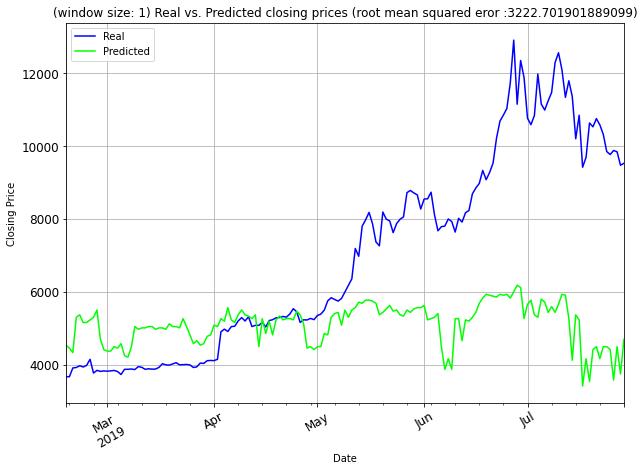

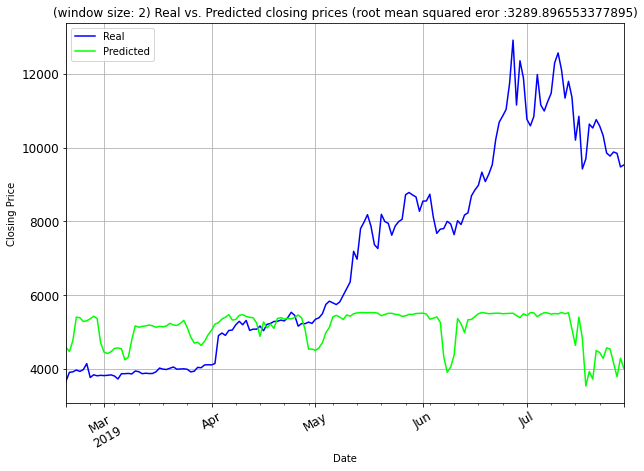

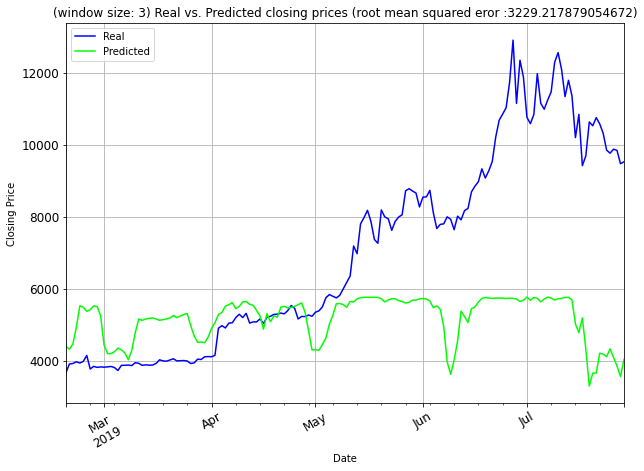

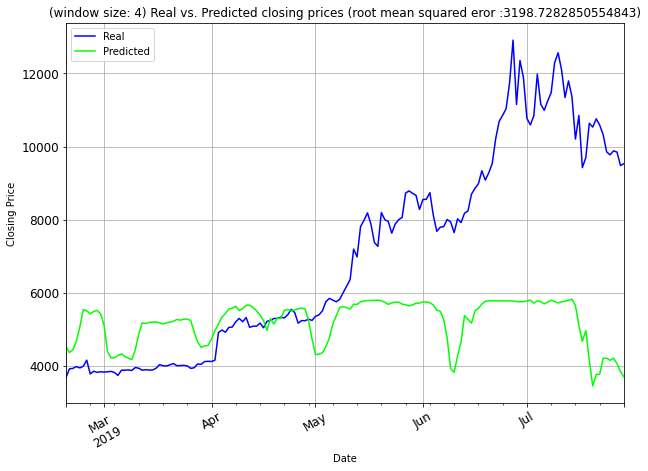

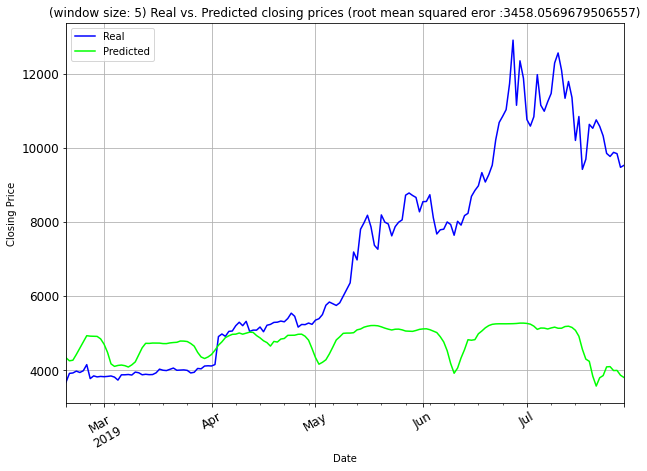

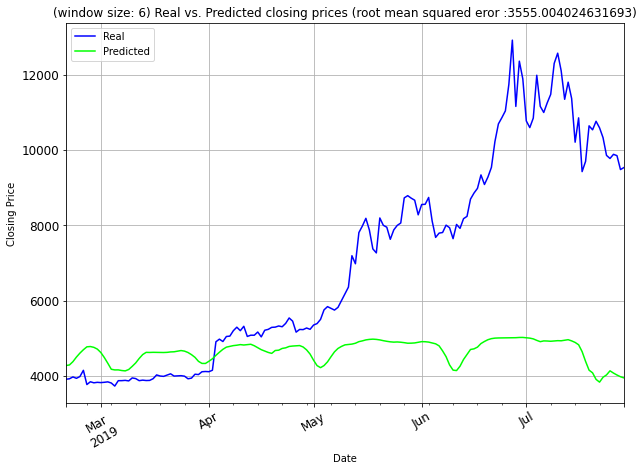

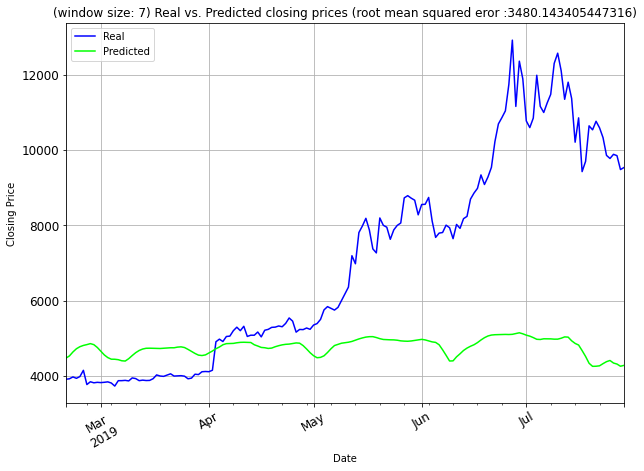

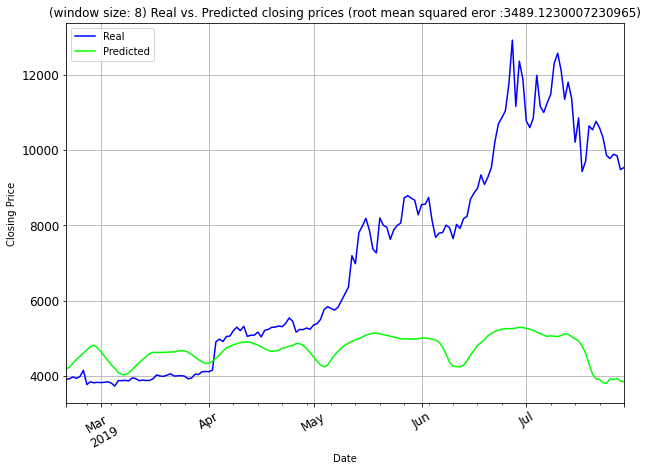

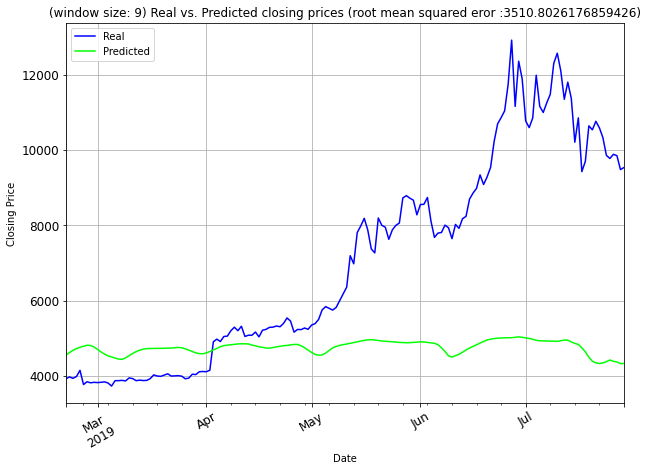

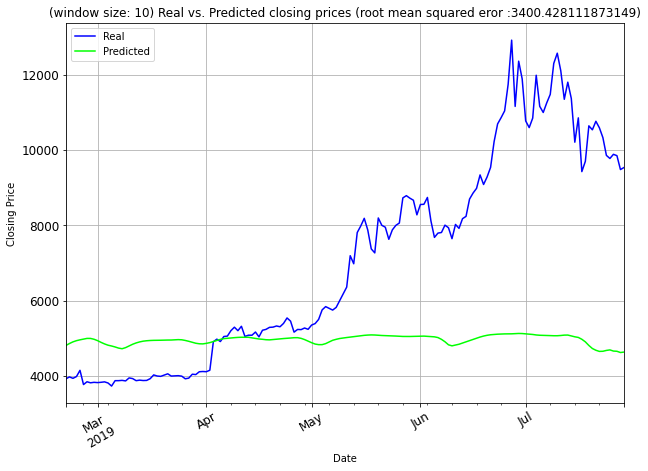

In [51]:
from IPython.display import display

for x in recurr:
  print(f"window_size:{x['window_size']} Real vs. Predicted closing prices")
  n_df = pd.DataFrame({"Real":x["Real"], "Predicted":x["Predicted"]}, index=x["index"])
  display(n_df.head())
  print()
  print()
  
  # Plot the real vs predicted values as a line chart
  n_df.plot(figsize = (10, 7), fontsize=12, rot=30, title = f"(window size: {x['window_size']}) Real vs. Predicted closing prices (root mean squared eror :{x['root_mse']})", 
            xlabel="Date", ylabel="Closing Price", grid=True, colormap='brg')

#BONUS 3: function to display the root mean squared error vs window size

,window,rmse
0,1,3222.701902
1,2,3289.896553
2,3,3229.217879
3,4,3198.728285
4,5,3458.056968
5,6,3555.004025
6,7,3480.143405
7,8,3489.123001
8,9,3510.802618
9,10,3400.428112


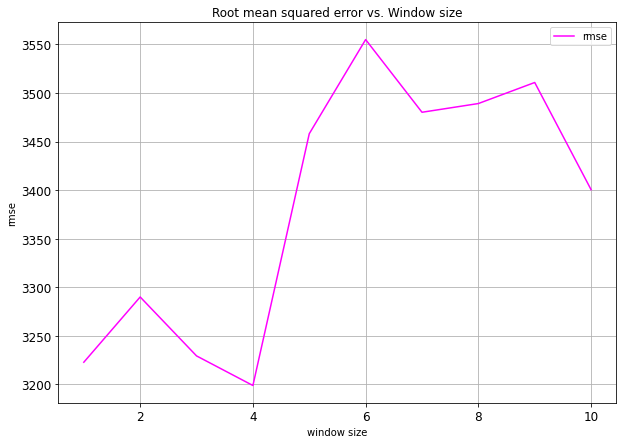

In [52]:
rmse = []
window = []
for x in recurr:
  rmse.append(x["root_mse"])
  window.append(x["window_size"])
  n_df2 = pd.DataFrame({"window":window, "rmse":rmse}) 

display(n_df2)

# Plot the window size vs root mean squared error as a line chart
n_df2.plot(x="window", y="rmse",  figsize = (10, 7), fontsize=12, rot=0, title = "Root mean squared error vs. Window size", 
            xlabel="window size", ylabel="rmse", grid=True, colormap='spring')

# Evaluate the performance of each model
Finally, use the testing data to evaluate each model and compare the performance.
Use the above to answer the following:

- Which model has a lower loss?

**Answer : the model with window size 5 days has a lower loss compared to the model with window size 10 days.**

- Which model tracks the actual values better over time?

**Answer : the model with window size 5 days tracks the actual values better over time compared to the model with window size 10 days.**

- Which window size works best for the model?

**Answer : window size 5 days works best for the model compared to the window size 10 days.**


# Conclusion

**Based on the results above considering the root(squared=False) mean squared error, window size 5 days is better than window size 10 days. Overall, compared to the model using closing prices as feature, this model using the FNG values as feature is worse to predict the next closing price, based on the root mean squared error of each model.**

Considering the BONUS functions, the model generates different rmse compared to the model I ran without using the BONUS functions for some reasons. With BONUS functions, as shown on the chart above "rmse vs. window size", window size 10 has slightly smaller rmse compared to window size 5. Overall, the model using fng values as feature do not have consistent pattern of rmse by window size unlike the model using closing price as feature.